## Import Libraries

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from datetime import timedelta, date
import datetime
import warnings
warnings.filterwarnings('ignore')
from fuzzywuzzy import process
from datetime import datetime, timedelta
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)

## Functions

The below function selects all the matches played between two players and then takes their last 50 matches between the two players. <br>
If there are less than 50 games played by the two opponents then the data is ignored.<br>
The number of draws in the last 50 games is divided by the number of games, which will always be 50.<br>
From this I can get a rough (allbeit simplistic) estimation of the % chance of a future draw, this % is then converted into betting odds.

In [86]:
def roi_check_draw(home,away,datetime):
    select_matches = matches.loc[(((matches['h']==home) & (matches['a']==away)) 
                                | ((matches['a']==home) & (matches['h']==away)))
                                & (matches['datetime']<datetime- timedelta(minutes=30))].tail(50)
    if (select_matches['draw'].count()<50) or select_matches['draw'].mean()==0:
        result = -1
    else:
        result = 1/select_matches['draw'].mean()
    return round(result,2)

The below function is used to match my odds dataset with my results dataset. <br>
Normally I would just be able to use pd.merge using ['datetime','h','a'] as my merged columns, but unfortunately the datetimes in both datasets sometimes have a slight difference by a few minutes 

In [87]:
def match_up(home,away,datetime):
    result = results.loc[(results['home']==home) & (results['away']==away)
        & (results['datetime']>=datetime - timedelta(minutes=20))
        & (results['datetime']<=datetime + timedelta(minutes=20))]['draw'].sum()
    return result

## Import Datasets/Data Cleaning

In [88]:
results = pd.read_csv('matches').iloc[:,2:].dropna()
results['datetime'] = pd.to_datetime(results['datetime'])-timedelta(hours=1)
# The website I scraped this data from was one hour ahead of the other website
results['home'] = results['home'].apply(lambda x: x.lower().replace('chellovekk','chellovek'))
results['away'] = results['away'].apply(lambda x: x.lower().replace('chellovekk','chellovek'))
# The player who went by the above name, was sometimes spelt different ways
results = results.drop_duplicates()
# This ensures each match only has a single row
results = results.loc[~((results['score'].str.contains('View')) | 
            (results['score'].str.contains('Cance'))| 
            (results['score'].str.contains('Aban')))]
# This takes out all matches which were not played - Abandoned/Cancelled etc
results = results.sort_values('datetime')
results = results.loc[results['datetime']>'2020-03-23 09:40:00'].sort_values('datetime')
# matching the dataset up with the other dataset time wise
print(min(results['datetime']))
print(max(results['datetime']))
results.head()

2020-03-23 09:48:00
2020-10-10 14:34:00


,datetime,home,away,score,draw
61678,2020-03-23 09:48:00,white_boy1927,blackstar98,1-2,0
61677,2020-03-23 09:48:00,mooneycb,inquisitor,1-1,1
61676,2020-03-23 09:52:00,lomik,kravark,2-1,0
61675,2020-03-23 09:52:00,arcos,mr.jab,1-0,0
61674,2020-03-23 10:03:00,mr.jab,lomik,0-0,1


In [101]:
odds = pd.read_csv('/Users/joepeirson/Documents/Data/odds/odds/esports_odds.csv')
odds = odds.loc[odds['tournament']=='Esoccer Battle - 8 mins play']
#  Select only the tournament I am interetsed in analysing
odds['h'] = odds['h'].apply(lambda x: x.lower().split('(')[1].split(')')[0])
odds['a'] = odds['a'].apply(lambda x: x.lower().split('(')[1].split(')')[0])
#  The dataset has the team names like this 'Man Utd (labotryas) Esports', so I split the name up so it just shows 'labotryas'
odds = odds.loc[odds['score']==0]
# makes sure all the rows have the score starting as a draw
odds = odds.drop(['tournament','h_price','a_price','score'], axis=1)
odds = odds.drop_duplicates(subset=['datetime','h','a'],keep='first')

odds['datetime'] = pd.to_datetime(odds['datetime'])
odds = odds.loc[odds['datetime']>'2020-03-23 09:40:00'].sort_values('datetime')
# matching the dataset up with the other dataset time wise
print(min(odds['datetime']))
print(max(odds['datetime']))
odds.head()

2020-09-05 20:24:00
2020-10-11 23:58:00


,datetime,h,a,d_price
24042,2020-09-05 20:24:00,vrico,skromnuy,2.80
24038,2020-09-06 12:12:00,foggy,bombi1t0,3.25
24039,2020-09-06 12:12:00,dangerdim77,slezaintima,2.30
24037,2020-09-06 12:24:00,rus_1995_lan,dangerdim77,2.80
24041,2020-09-06 12:24:00,slezaintima,foggy,2.50


In [146]:
df = odds.loc[(odds['d_price']!=1.01) & (odds['d_price']<=3)]
print(df.shape[0])
df = df.sort_values('datetime')
df['draw_proj'] = df.apply(lambda x: roi_check_draw(x['h'],x['a'],x['datetime']),axis=1)
# df['total_games'] = df.apply(lambda x: total_games(x['h'],x['a'],x['datetime']),axis=1)
df['roi'] = df['d_price']/df['draw_proj']-1
# df['datetime_round'] = df['datetime'].dt.round('90min')
df['draw_result'] = df.apply(lambda x: match_up(x['h'],x['a'],x['datetime']),axis=1)
df['profit'] = df.apply(lambda x: x['d_price']-1 if x['draw_result']==1 else -1,axis=1)

The functions took a few hours to run, so I run it over night and then saved it to a csv so I didn't have to do this multiple times

In [8]:
# data.to_csv('analysis_last_50_games')
# data.to_csv('analysis_last_50_games', mode='a', header=False)
df = pd.read_csv('analysis_last_50_games').iloc[:,1:]
df['datetime'] = pd.to_datetime(df['datetime'])
df.tail(10)

,datetime,match_time,h,a,draw_odds,draw_proj,roi,draw_result,profit
47309,2020-10-08 13:52:00,00:00,dangerdim77,d1psen,2.800,2.63,0.064639,0,-1.000
47310,2020-10-08 13:52:00,00:00,orlovsky1,white_boy1927,2.750,3.85,-0.285714,0,-1.000
47311,2020-10-08 14:04:00,00:00,d1psen,orlovsky1,2.700,2.38,0.134454,0,-1.000
47312,2020-10-08 14:04:00,00:00,slezaintima,dangerdim77,2.250,2.50,-0.100000,0,-1.000
47313,2020-10-08 14:16:00,00:00,white_boy1927,d1psen,3.000,2.94,0.020408,0,-1.000
47314,2020-10-08 14:16:00,00:00,orlovsky1,slezaintima,2.250,2.78,-0.190647,0,-1.000
47315,2020-10-08 14:28:00,00:00,dangerdim77,orlovsky1,2.375,2.63,-0.096958,1,1.375
47316,2020-10-08 14:28:00,00:00,slezaintima,white_boy1927,2.500,3.33,-0.249249,0,-1.000
47317,2020-10-08 14:58:00,00:00,pablik,inquisitor,2.500,2.63,-0.049430,1,1.500
47318,2020-10-08 14:58:00,00:00,olle,taka,2.625,2.94,-0.107143,0,-1.000


# Data Analysis
I now had the data nicely formatted. I had the date, the home and away team. Then the draw price vs my draw projection, with the projected roi. Finally, I had the draw result and the profit/loss from this, which meant I could easily back test. <br>
I started by subsetting the data into just the rows that showed a ROI above a certain %. <br>
As you can see the results are very good. As my projected roi increases, the actual roi increase at a very similar rate. This is also visualized in thr graph below.

In [144]:
my_proj_roi = []
actual_roi = []
for x in range(1,10):
    over_this_roi = x/10
    df1 = df.loc[(df['roi']>over_this_roi)]
    print('all bets over',over_this_roi,'my roi:',round(df1['profit'].mean(),2),
          'bets:',df1['profit'].count(),
          'sum:',round(df1['profit'].sum(),2))
for x in range(1,100):
    proj_roi = x/100
    my_proj_roi.append(proj_roi)
    roi = round(df.loc[(df['roi']>=proj_roi)]['profit'].mean(),3)
    actual_roi.append(roi)

all bets over 0.1 my roi: 0.06 bets: 7862 sum: 474.57
all bets over 0.2 my roi: 0.12 bets: 4148 sum: 490.82
all bets over 0.3 my roi: 0.15 bets: 2101 sum: 319.5
all bets over 0.4 my roi: 0.26 bets: 834 sum: 214.6
all bets over 0.5 my roi: 0.39 bets: 378 sum: 148.82
all bets over 0.6 my roi: 0.48 bets: 209 sum: 100.12
all bets over 0.7 my roi: 0.63 bets: 108 sum: 67.85
all bets over 0.8 my roi: 0.99 bets: 55 sum: 54.52
all bets over 0.9 my roi: 1.01 bets: 38 sum: 38.2


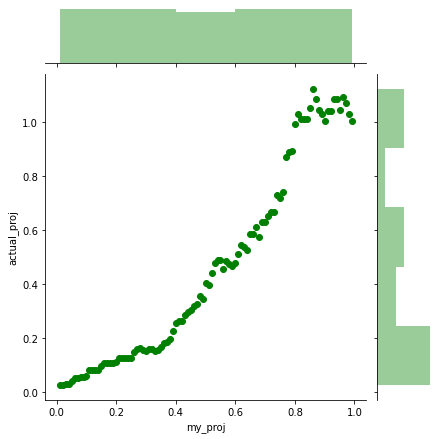

In [143]:
import seaborn as sns
data_viz = sns.jointplot(x = my_proj_roi, y = actual_roi, color = 'g')
data_viz.set_axis_labels('my_proj', 'actual_proj')

# Conclusions
From fairly simple analysis, it is clear it is very profitable to back draws in esports matches, when looking at certain players previous matches against each other. <br>
This shows that simplistic analysis can be very benefitcal when you make sure are answering your chosen question directly and the analysis mimics the real world. <br>
I carried out this analysis after a few months of betting on esports, and was able to generate fast profits making over five figures in the first month.